# *Hydraulic Systems Dataset*

Este *notebook* tem como objetivo identificar a condição de um trocador de calor responsável pela refrigeração do óleo de um sistema hidráulico. Para tanto, será utilizado o conjunto de dados [*Condition Monitoring of Hydraulic Systems Dataset*](https://archive.ics.uci.edu/ml/datasets/Condition+monitoring+of+hydraulic+systems), que contém registros de diversos sensores instalados em uma bancada hidráulica. Em relação à instrumentação, variáveis como pressão, temperatura, vazão, aceleração e potência são colhidas durante 60 segundos, tempo correspondente aos testes realizados.

## Sobre o conjunto de dados
Os experimentos consistiam em um sistema primário de trabalho e um sistema secundário de resfriamento e filtragem, ambos conectados por um reservatório de óleo. O sistema era submetido às cargas cíclicas de 60 segundos de duração. A cada ciclo, as variáveis do processo eram manipuladas com o intuito de variar a condição dos quatro componentes monitorados: trocador de calor, válvula, bomba e acumulador.

O *dataset* fornecido contém dados brutos dos sensores, com diferentes taxas de amostragem e organizados em forma matricial com separação por **tab**. Cada linha da matriz representa um determinado ciclo, enquanto as colunas representam uma coleta dentro dos 60 segundos de execução do teste. Cada arquivo representa um sensor específico:

| Sensor | Variável do processo | Unidade | Amostragem |
| :-: | :-: | :-: | :-: |
| PS1 | Pressão | bar | 100 hz |
| PS2 | Pressão | bar | 100 hz |
| PS3 | Pressão | bar | 100 hz |
| PS4 | Pressão | bar | 100 hz |
| PS5 | Pressão | bar | 100 hz |
| PS6 | Pressão | bar | 100 hz |
| EPS1 | Potência do motor | W | 100 hz |
| FS1 | Vazão | L/min | 10 hz |
| FS2 | Vazão | L/min | 10 hz |
| TS1 | Temperatura | ºC | 1 hz |
| TS2 | Temperatura | ºC | 1 hz |
| TS3 | Temperatura | ºC | 1 hz |
| TS4 | Temperatura | ºC | 1 hz |
| VS1 | Vibração | mm/s | 1 hz |
| CE | Eficiência do resfriamento | % | 1 hz |
| CP | Potência virtual do resfriamento | kW | 1 hz |
| SE | Fator de eficiência | % | 1 hz |

Os rótulos, por sua vez, estão contidos em um arquivo à parte e, como as *features*, estão organizados de forma que as linhas representam o número do ciclo e as colunas as condições monitoradas. São elas:

| Condição do trocador de calor [%] | Condição da válvula [%] | Vazamento interno da válvula | Acumulador hidráulico [bar] | Condição de estabilidade |
| :-: | :-: | :-: | :-: | :-: |
| 3: próximo da falha catastrófica | 73: próximo da falha catastrófica | 0: sem vazamento | 90: próximo da falha catastrófica | 0: condições estavam estáveis |
| 20: eficiência reduzida; | 80: lag severo | 1: pouco vazamento | 100: redução severa de pressão | 1: condições estáticas talvez não tenham sido alcançadas |
| 100: eficiência completa. | 90: lag baixo | 2: vazamento severo | 115: baixa redução de pressão | - |
| - | 100: condição ótima | - | 130: pressão ótima | - |

<p align=center><img src=./img/hydroSystem.png></p>

<p align=center>Fonte: Helwig, Pignanelli e Schütze, 2015</p>

## Problematização e objetivos
Embora o conjunto de dados apresentado possua informação que possibilite a identificação da condição de todos os componentes monitorados durante os testes, a solução aqui apresentada, como já comentado, será direcionada para a identificação da condição do *cooler*. Dessa forma, o intuito do projeto é desenvolver um modelo que seja capaz de identificar a condição do trocador de calor com precisão e acurácia.

Como uma forma de aproximar o problema de uma situação normal, pode-se criar uma situação hipotética. Suponha que a troca de um *cooler* sob condição de "falha total" custe R$1.500,00. Entretanto, um erro na identificação dessa falha pode sobrecarregar outros componentes do sistema, elevando o custo da troca para R$2.500,00. Por outro lado, foi verificado que a identificação correta da degradação do trocador de calor provoca uma economia de R$500. Dessa forma, caso a identificação da condição de baixa eficiência ocorra de maneira satisfatória, pode-se reduzir o custo com manutenção.

Mesmo que os valores apontados sejam completamente arbitrários e a situação posta acima seja relativamente simples, ao problematizar uma solução baseada em ciência de dados, pode-se avaliar o modelo não só em relação às métricas tradicionais de um problema de classificação, mas também por meio de uma regra de negócio.

# Importações

In [1]:
# Ferramentas matemáticas
import numpy as np
import pandas as pd

# ferramentas de visualização
import cv2
import matplotlib.pyplot as plt
import seaborn as sns

# utilitários
from hydro_utils import process, plots, models
from sklearn.model_selection import train_test_split

# Carregamento dos dados

Como já comentado, o conjunto de dados *Hydraulic Systems Dataset* possui a peculiaridade de estar organizado de uma forma não tabular, mas em um formato tridimensional. Além dessa organização em três dimensões, as *features* do *dataset* não possuem o mesmo número de observações, uma vez que há diferentes taxas de amostragem.

Em relação ao tamanho da amostra de cada sensor, deve-se optar por um tratamento que garanta que todas as variáveis possuam o mesmo tamanho, tendo em vista que é necessário que todas elas possuam a mesma correspondência temporal com o sistema hidráulico. Para tanto, pode-se lançar mão de uma reamostragem por *downsampling*, reduzindo as observações dos sensores de 100 e 10 hz para 1 hz, ou por *upsampling*, criando dados artificiais para aumentar o número de observações das variáveis de 1 e 10 hz para 100 hz.

Neste *notebook*, opta-se por uma abordagem de *upsampling*, utilizando-se uma interpolação linear entre pontos vizinhos. Entretanto, observe que qualquer que seja a decisão, deve-se atentar com a possível perda ou modificação das informações dos sinais.

In [2]:
# carregamento dos dados após upsampling
data, labels = process.load_hydroSystem('./datasets/hydro/')

Carregamento dos conjuntos de dados:


100%|██████████| 18/18 [00:24<00:00,  1.35s/it]


Processamento dos dados:


100%|██████████| 2205/2205 [00:10<00:00, 201.62it/s]


Como uma forma de verificação das diferenças entre os dados originais e os dados processados com *upsampling*, optou-se por analisar os sinais das variáveis "VS1" (1 hz) e "FS1" (10 hz). Verifica-se uma boa correspondência entre as variáveis tratadas e as originais. Entretanto, pode-se observar uma certa translação entre os dois sinais, principalmente para as variáveis colhidas a 1 hz.

Mesmo que a interpolação usada durante a etapa de *upsampling* tenha causado a diferença observada, cria-se a hipótese de que essa transformação não tenha modificado a informação dos sinais, possibilitando que essas variáveis processadas possam ser utilizadas para o treinamento de um modelo de aprendizado de máquina.

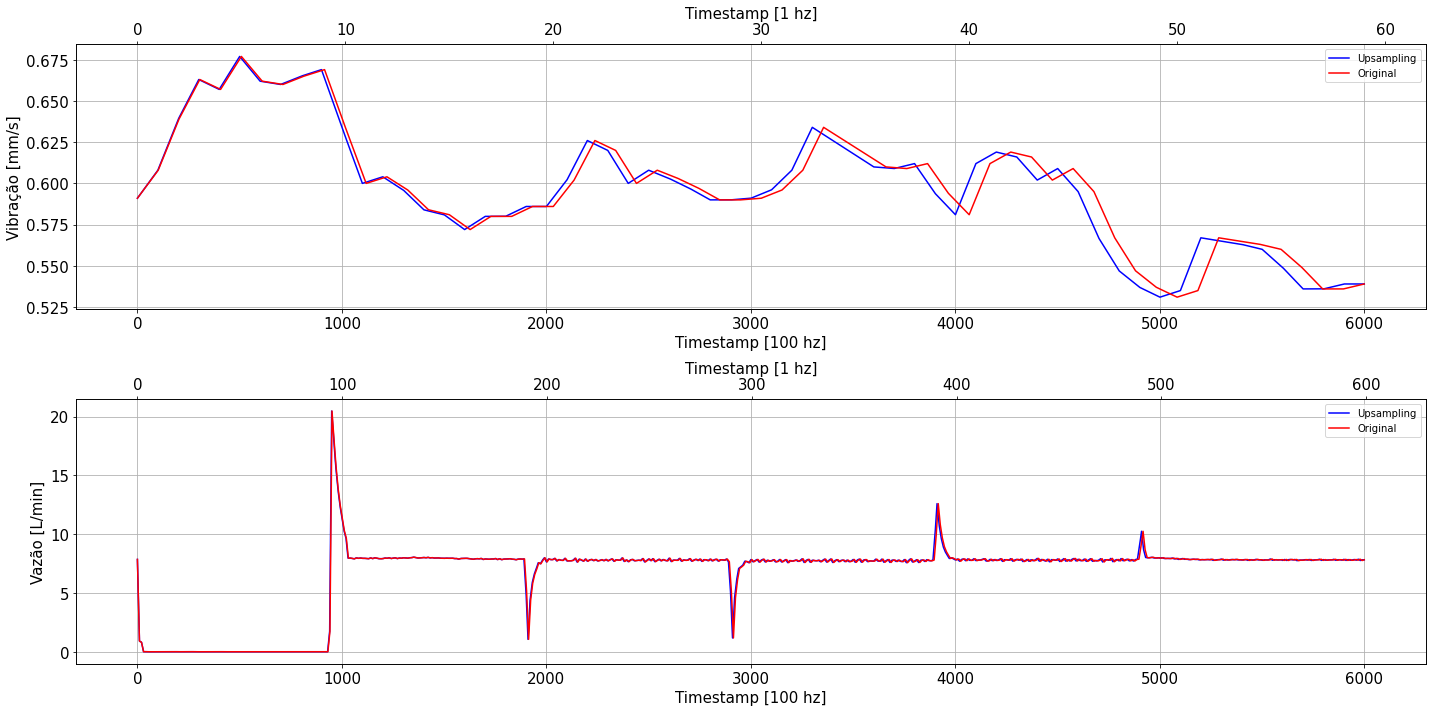

In [3]:
# Comparação entre os dados tratados e os dados originais, em relação à frequência de amostragem
plots.compare_data(data)

# Análise exploratória dos dados

Embora os dados estejam organizados por experimentos individuais, a visualização temporal dos sensores pode se mostrar interessante para a análise dos comportamentos das variáveis físicas em relação aos diferentes modos da falha. O *time plot* abaixo ilustra os sinais para um experimento aleatório.

Pode-se verificar que muitas variáveis possuem comportamentos distintos para cada modo de falhado *cooler*: falha total, baixa eficiência e alta eficiência. Em especial, as variáveis relacionadas à temperatura possuem patamares muito distintos para as três condições possíveis.

In [4]:
# Análise dos sinais
plots.timeplots(data, labels)

Como uma forma de visualizar o conjunto de dados com mais facilidade, opta-se por organizar os dados de forma tabular. A identificação dos experimentos se dá por meio de uma coluna específica, bem como a condição do sistema em relação ao trocador de calor. Dessa forma, os dados que até então se apresentavam por um tensor de 3 dimensões, passa a ser um DataFrame tradicional.

In [5]:
tab_data = process.create_hydrodf(data, labels)
tab_data

100%|██████████| 2205/2205 [05:59<00:00,  6.13it/s]


PS1     PS2    PS3     PS4     PS5    PS6    FS1      FS2       TS1  \
0     151.47  125.50  2.305   0.000   9.936  9.818  8.990  10.1790  35.57000   
1     151.45  125.39  2.305   0.000   9.947  9.823  8.168  10.1785  35.56922   
2     151.52  125.40  2.336   0.000   9.964  9.844  7.346  10.1780  35.56844   
3     151.27  125.03  2.578   0.000   9.989  9.861  6.524  10.1775  35.56766   
4     150.80  124.05  2.977   0.000   9.996  9.877  5.702  10.1770  35.56688   
...      ...     ...    ...     ...     ...    ...    ...      ...       ...   
5995  151.64  125.73  2.305  10.204   9.989  9.870  7.774  10.1760  35.42600   
5996  151.70  125.81  2.320  10.238  10.007  9.882  7.774  10.1760  35.42600   
5997  151.73  125.77  2.273  10.223  10.007  9.886  7.774  10.1760  35.42600   
5998  151.71  125.66  2.227  10.218   9.988  9.870  7.774  10.1760  35.42600   
5999  151.70  125.77  2.250  10.212   9.964  9.854  7.774  10.1760  35.42600   

           TS2       TS3       TS4    EPS1      VS1        CE     CP  \
0     40.96100  38.32000  30.36300  2411.6  0.60400  47.20200  2.184   
1     40.96088  38.32012  30.36312  2411.6  0.60401  47.20271  2.184   
2     40.96076  38.32024  30.36324  2411.6  0.60402  47.20342  2.184   
3     40.96064  38.32036  30.36336  2411.6  0.60403  47.20413  2.184   
4     40.96052  38.32048  30.36348  2411.6  0.60404  47.20484  2.184   
...        ...       ...       ...     ...      ...       ...    ...   
5995  40.89100  38.18700  30.37500  2416.2  0.53100  46.62100  2.148   
5996  40.89100  38.18700  30.37500  2416.6  0.53100  46.62100  2.148   
5997  40.89100  38.18700  30.37500  2416.8  0.53100  46.62100  2.148   
5998  40.89100  38.18700  30.37500  2417.0  0.53100  46.62100  2.148   
5999  40.89100  38.18700  30.37500  2417.0  0.53100  46.62100  2.148   

            SE   exp  condition  
0     68.03900     1          3  
1     67.35861     1          3  
2     66.67822     1          3  
3     65.99783     1          3  
4     65.31744     1          3  
...        ...   ...        ...  
5995  68.11700  2205        100  
5996  68.11700  2205        100  
5997  68.11700  2205        100  
5998  68.11700  2205        100  
5999  68.11700  2205        100  

[13230000 rows x 19 columns]

Como uma alternativa à visualização temporal, pode-se avaliar as distribuições dos sensores. Observa-se que, além das temperaturas, as variáveis colhidas pela instrumentação da linha de refrigeração e filtragem possuem uma boa correlação com as condições do *cooler*, sob o ponto de vista de distribuição. Os sensores do sistema primário de trabalho, por outro lado, aparentam não possuir uma relação direta.

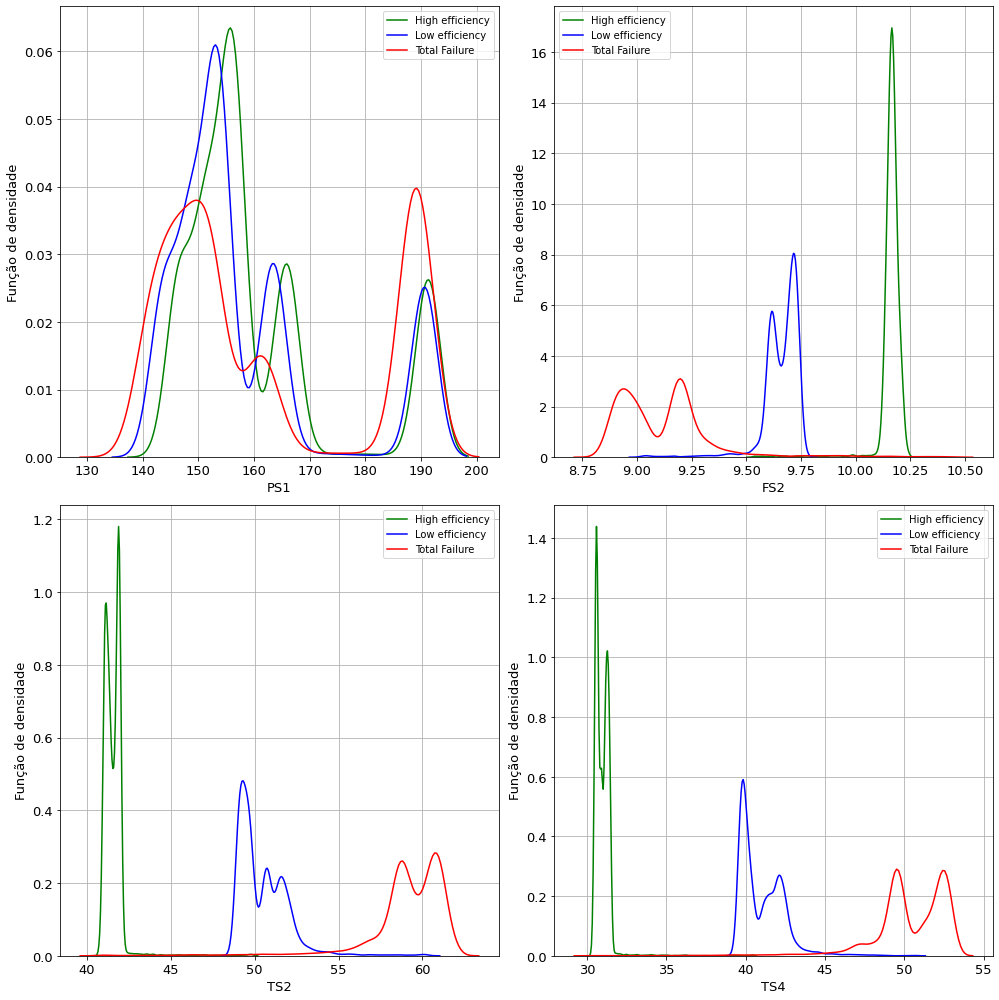

In [6]:
# distribuição dos dados
plots.dist_plot(tab_data, sensors=['PS1', 'FS2', 'TS2', 'TS4'])

Embora as funções de densidade tenham mostrado que os sensores do sistema primário não possuem uma correlação direta com a variável *target*, é natural imaginar que a condição do trocador de calor impacta em toda dinâmica do sistema. Essa hipótese pode ser validada por meio do gráfico de correlações bivariadas abaixo. Pode-se ver que variáveis como "PS1" e "PS2" possuem alta correlação não linear com a condição do *cooler*, mas uma baixa correlação linear e monotônica.

Além disso, as altas correlações mostradas no gráfico supracitado indicam que um modelo de aprendizado de máquina consiga lidar facilmente com o problema. Por esse motivo, opta-se por direcionar o desenvolvimento da solução de forma a não utilizar sensores contidos na linha de refrigeração e filtragem. Dessa maneira, o modelo será robusto o suficiente para verificar a condição do *cooler* sem o acesso a uma informação direta do sistema. Com isso, além do modelo ser capaz de realizar a predição requerida, espera-se que ele possibilite a exclusão da necessidade de alguns sensores.

In [7]:
plots.corr_plot(tab_data)

O estudo de redundância mostra a existência de muitos sensores que apresentam a mesma informação (Pearson maior que 0.95). Em especial, as variáveis relacionadas à temperatura. Isso indica que as temperaturas do óleo hidráulico nas diferentes partes do sistema possuem o mesmo comportamento. Em geral, com exceção do sensor "PS4", todos as variáveis relacionadas ao circuito de refrigeração possuem grande redundância entre elas.

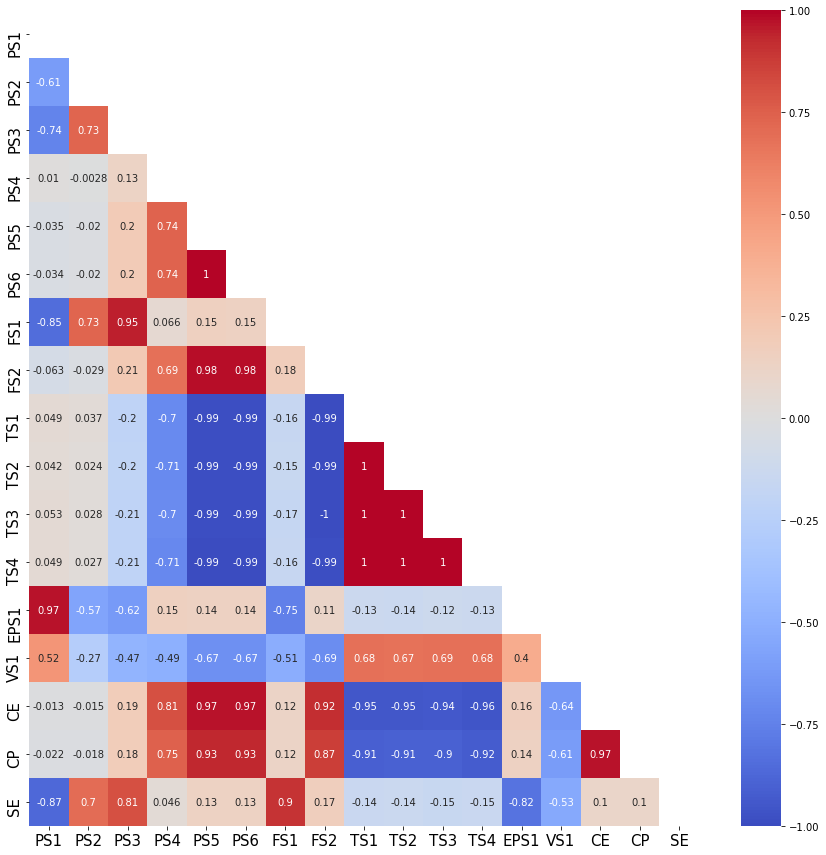

In [ ]:
plots.redundant_features(tab_data)

## Modelo *baseline*

Como foi observado que as variáveis relacionadas à temperatura do fluido hidráulico possuem uma correlação direta com a variável alvo, como já era natural se imaginar, opta-se por utilizar essa informação para a criação de um modelo base para a identificação da condição do *cooler*. Pode-se verificar que com a utilização direta da temperatura, pode-se chegar a um modelo muito simples que apresenta métricas muito boas, mesmo que tenha uma certa dificuldade em identificar problemas de falha total (*recall* de 95%) e problemas com falsos alarmes na identificação de baixa eficiência (*precision* de 95%).

In [ ]:
# verificação de um modelo baseline
bl_model = models.baseline_model(45, 55)
bl_model.report(tab_data['TS2'], tab_data['condition'])

              precision    recall  f1-score   support

           3       0.98      0.95      0.97   4392000
          20       0.95      0.98      0.97   4392000
         100       0.99      0.99      0.99   4446000

    accuracy                           0.98  13230000
   macro avg       0.98      0.98      0.98  13230000
weighted avg       0.98      0.98      0.98  13230000



# Pré Processamento

Como já citado, o modelo que será criado terá que ser capaz de identificar a condição do *cooler* apenas com informações do sistema primário de trabalho. Dessa maneira, deve-se retirar as variáveis participantes do sistema de refrigeração e filtragem. Além disso, retira-se as variáveis redundantes com o objetivo de agilizar a etapa de treinamento.

In [ ]:
# identificação das variáveis redundantes e dos sensores que participam do circuito de resfriamento
red_feat = ['PS6', 'FS1', 'FS2', 'TS1', 'TS2', 'TS3', 'TS4', 'EPS1', 'CE', 'CP']
cooler_line_feat = ['PS4', 'PS5']

# criação das colunas que serão excluidas
dropped_cols = np.r_[red_feat, cooler_line_feat]
tab_cols = pd.Series(tab_data.drop(columns=['exp', 'condition']).columns)
selected_index = tab_cols[~tab_cols.isin(dropped_cols)].index

# seleção do conjunto visado
processed_data = data[:, :, selected_index]

Embora seja possível utilizar o formato tabular como entrada do modelo, fornecendo apenas uma informação pontual durante o treinamento, mostra-se mais interessante providenciar uma informação temporal. Dessa forma, o modelo de aprendizado de máquina poderá avaliar padrões existentes durante todo o experimento para avaliar a condição do trocador de calor. Com isso, a entrada do modelo passa a ser bidimensional, podendo ser interpretado como uma imagem.

[]

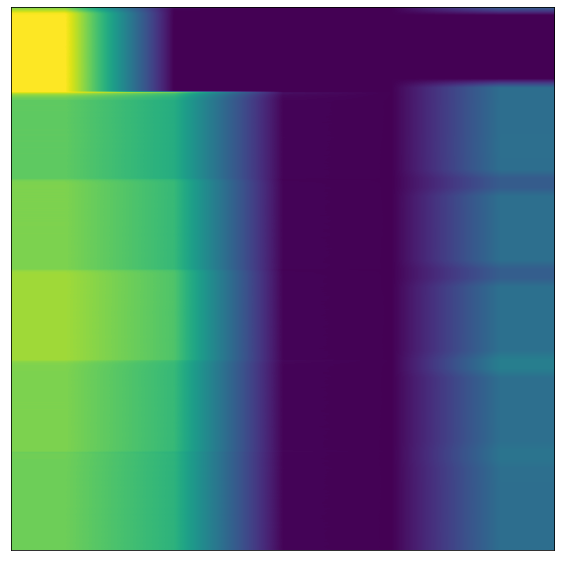

In [ ]:
# separação em conjunto de treino e teste
train_x, test_x, train_y, test_y = train_test_split(processed_data, labels, test_size=.2, random_state=42)

# visualização da entrada do modelo
fig, ax = plt.subplots(figsize=(10,10))
ax.imshow(cv2.resize(train_x[0], (800,800)))
ax.set_xticks([])
ax.set_yticks([])


# Treinamento do modelo

O modelo escolhido é um classificador do tipo Floresta de Decisões Aleatórias. Por esse motivo, uma vez que modelos baseados em árvores não são sensíveis à normalização ou escalonamento, nenhum outro pré processamento é necessário.

In [ ]:
# criação e treinamento do modelo
rf_cls = models.RF_classifier(random_state=42)
rf_cls.train(train_x, train_y)

## Avaliação do modelo

Durante a etapa de otimização dos hiperparâmetros de um modelo, é comum que sejam realizados vários treinamentos. Com isso, o cientista de dados pode provocar um *overfitting* no conjunto de testes. Por esse motivo, é normal criar um terceiro conjunto para a validação do modelo, usado para avaliar a variação da performance em relação à mudança de hiperparâmetros. Entretanto, em alguns casos, a separação do *dataset* original em três subconjuntos pode criar um problema de falta de dados durante a etapa de treinamento.

Como uma forma de sanar o problema exposto, pode-se lançar mão da validação cruzada. Nessa técnica, em seu modo tradicional, o conjunto de dados de treino é separada em "k" pastas. Posteriormente, o treinamento do modelo é feito utilizando "k-1" pastas, enquanto a validação é feita na pasta separada. Esse processo é repetido até que todas as pastas possam ser usadas como um conjunto de validação, garantindo a verificação da performance do modelo para diferentes conjuntos de treino e diferentes conjuntos de validação. Ao final do processo de otimização, pode-se realizar a predição do conjunto de dados teste, nunca visto durante o desenvolvimento do modelo.

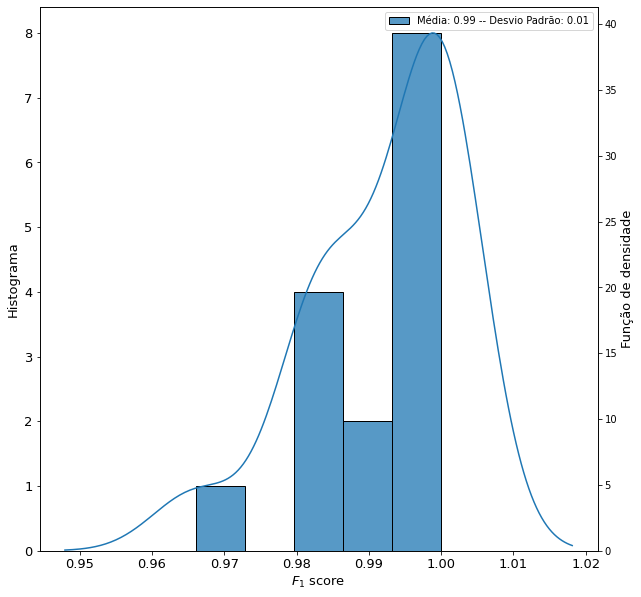

In [ ]:
# Cross validation do modelo
rf_cls.report(train_x, train_y, cross=True)

In [ ]:
# performance no conjunto de testes
rf_cls.report(test_x, test_y)

              precision    recall  f1-score   support

           3       0.97      1.00      0.99       152
          20       1.00      1.00      1.00       135
         100       1.00      0.97      0.99       154

    accuracy                           0.99       441
   macro avg       0.99      0.99      0.99       441
weighted avg       0.99      0.99      0.99       441



# Conversão das métricas do modelo para métricas de negócio

Após o treinamento do modelo, pode-se realizar uma conversão entre as métricas do modelo de aprendizado de máquina, tais como *precision* e *recall*, em métricas de negócio. No problema colocado no início deste *notebook*, a métrica de negócio visada é o custo com manutenção e troca do trocador de calor. Como pode ser observado abaixo, embora a diferença entre as métricas de modelo do classificador baseado em árvore de decisão e do modelo base não seja grande, o impacto da métrica de negócio é. O modelo RandomForest é capaz de reduzir o custo de manutenção e substituição do *cooler* em R$38.000,00, apresentando uma redução de 44% quando comparado com o *baseline model*. 

In [ ]:
# seleção de uma amostra aleatória para a avaliação da métrica de negócio
np.random.seed(42)
rand = np.random.randint(data.shape[0], size=200)

sampled_data = data[rand, :, :]
temps = sampled_data[:, :, 8].mean(axis=1)
sample_x = sampled_data[:, :, selected_index]
sample_y = labels[rand]

In [ ]:
# conversão
cost_df = models.metrics_conversion(bl_model, rf_cls, sample_x, temps, sample_y.values)
cost_df

baseline  model  actual  baseline_cost  model_cost
0          20     20      20           -500        -500
1         100     20      20              0        -500
2         100     20      20              0        -500
3         100     20      20              0        -500
4         100    100     100              0           0
..        ...    ...     ...            ...         ...
195         3      3       3           1500        1500
196        20     20      20           -500        -500
197        20     20      20           -500        -500
198       100    100     100              0           0
199       100     20      20              0        -500

[200 rows x 5 columns]

In [ ]:
# verificação dos custos de manutenção e substituição
model_cost = cost_df['model_cost'].sum()
baseline_cost = cost_df['baseline_cost'].sum()

print(f'Custo com manutenção:')
print(f'Modelo base: R${baseline_cost}.')
print(f'Modelo RandomForest: R${model_cost}.')
print(f'Redução de R${baseline_cost - model_cost}.')

Custo com manutenção:
Modelo base: R$86000.
Modelo RandomForest: R$48000.
Redução de R$38000.


# Considerações finais

A solução apresentada neste *notebook* demonstra a capacidade de extração de informação de um modelo de aprendizado de máquina. O modelo criado, apesar de simples, além de ser capaz de identificar a condição do trocador de calor por meio da análise de sensores que fazem parte da instrumentação do sistema ao qual o equipamento pertence, é capaz de indicar a condição do *cooler* com precisão e acurácia.

Embora o modelo *baseline* indicasse boas métricas, e mesmo que a diferença entre as performances do classificador criado e do modelo base aparentemente não tenha sido muito grande, o impacto na métrica de negócio foi muito significativo. O modelo criado foi capaz de reduzir o custo com manutenção e troca em 44% para a amostra selecionada aleatoriamente, garantindo uma economia de R$38.000,00.

# Referências bibliográficas
HELWIG, Nikolai; PIGNANELLI, Eliseo; SCHÜTZE, Andreas. Condition monitoring of a complex hydraulic system using multivariate statistics. In: **2015 IEEE International Instrumentation and Measurement Technology Conference (I2MTC) Proceedings**. IEEE, 2015. p. 210-215.